***

$$
\Large{\textbf{Conformal Prediction - Unit TER 2023}}
$$

***

$$
\large{\text{Emilio PICARD - Sorbonne University LPSM}}
$$

$$
    \text{Under the supervision of Claire Boyer.}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Introduction

Goal: Starting from any model, with a dataset $(X_i, Y_i){i=1,...,n}$ and a given data $X{test}$, we want to predict a corresponding $Y$ for the given $X_{test}$.

For $Y \in \mathbb{R}$, we will refer to a prediction interval of level $1-\alpha$, where $\alpha$ is our desired error. In the following, it will be denoted as $\mathcal{\hat{C}}$.

For $Y \in {1,...,C}, \, \, C < \infty$, we will refer to prediction classes at levels $1-\alpha$.

## Modeling the Problem for $Y \in \mathbb{R}$

#### Assumptions

Let $(X_i,Y_i)_{i=1,...,n} \sim \mathcal{P}_{XY}$, where $(X_i,Y_i)$ are independent and identically distributed (iid) for all $i \in \{1,...,n\}$.

Goal: Construct an interval $\mathcal{\hat{C}}$ that satisfies $\mathbb{P}(Y_{test} \in \mathcal{\hat{C}}(X_{test})) = 1-\alpha,$ regardless of the distribution $\mathcal{P}_{XY}$, which is not necessarily known.

Definition of the quantile function:
$$\text{Quantile}(1-\alpha,\mathbb{F})= \left\{ z:\mathbb{P}(Z\le z) \ge 1-\alpha \right\},$$

where $\mathbb{F}$ is the cumulative distribution function of $Z$ with distribution $\mathcal{P}_{XY}$.

Later on, we will see that $\mathbb{F}$ will be calculated empirically (which makes sense since we have no information about $\mathcal{P}_{XY}$; thus, we will denote it as $\mathbb{F}_n$).

Thus, for a family $v_{1:n}={v_1,...,v_n}$, we define $$\text{Quantile}\left(1-\alpha;v_{1:n}\right) = \text{Quantile}\left(1-\alpha;\frac{1}{n}\sum_{i=1}^n\delta_{v_i}\right).$$

Note: The notation $\delta_{v_i}$ represents the Dirac delta function centered at $v_i$.

>**Proposition** : if $V_1,...,V_n \,\,\, \text{are} \, iid$, then : $$\forall \,\, \alpha \in [0,1], \, \, \mathbb{P}\big(V_{n+1} \leq \text{Quantile}(1-\alpha;V_{1:n} \cup \{\infty\})\big) \ge 1-\alpha.$$
>>**Proof.** Let's denote $\beta$ as $1-\alpha$.
>>$$ \bigg\{V_{n+1} \leq \mathcal{Q}(\beta;V_{1:n} \cup \{\infty\})\bigg\} \Leftrightarrow \bigg\{ \frac{1}{n+1} \lvert j : V_j \leqslant V_{n+1} \rvert \leqslant \beta \bigg\}  \Leftrightarrow  \bigg\{\frac{\text{rank}(V_{n+1})-1}{n+1} \leq \beta \bigg\}  \Leftrightarrow  \bigg\{\text{rank}(V_{n+1}) \leq \beta(n+1) + 1 \bigg\} $$
>>Thus, $$\mathbb{P}\big(V_{n+1}\leq \text{Quantile}(\beta;V_{1:n}\cup\infty)\big) =\mathbb{P}\big(\text{rank}(V_{n+1})\leq 1+\beta(n+1)\big) = \frac{1+\beta(n+1)}{n+1}=\beta + \frac{1}{n+1} \ge \beta = 1-\alpha, $$ using the fact that $\text{rank}(V_{n+1})\sim \mathcal{U}\{1,...,n+1\}.
$
>>


Now, let's suppose we have a dataset $\mathcal{Z}=(X_i,Y_i)_{i=1,...,n}$ and a point $(x,y)$ that we want to test. We also need a Score function, denoted as $\mathcal{S}((x,y),\mathcal{Z})$. A high score will indicate that $(x,y)$ does not conform to our model, while a low score will indicate that $(x,y)$ is consistent with $\mathcal{Z}$.

In the context of this work, we will always use the following score function:
$$
\mathcal{S}((x,y),\mathcal{Z}) = \lvert y - \hat{\mu}(x)\rvert,
$$

where $\hat{\mu}$ is a regression function trained by an algorithm $\mathcal{A}$ on $(x,y)$ and $\mathcal{Z}$. For a Linear Regression model, $\hat{\mu}$ will be the least squares estimator.

***

## **Different methods of predictions to approach $\hat{\mathcal{C}}$**

###  Full Conformal

###  Split Conformal

###  Jackknife +

###  Cross Validation +

**Remark.** $\hat{\mathcal{C}}$ will be graphically represented for each of the methods, and $\hat{\mu}$ will be calculated either through k-nearest neighbors (KNN) or by ordinary least squares (OLS).

In [29]:
np.random.seed(1)

Importing the SKLEARN library to implement the model:

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [30]:
# evaluation of the models

reg_OLS = LinearRegression()

# choice of the hyper-parameter k
k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)

***

# FULL CONFORMAL

#### Implementation of the Algorithms.

Instead of plotting a prediction interval at a fixed $\alpha$ level, we will plot contour lines at level $\alpha$.
Therefore, our algorithm will return a score $C\big(x_{test},y | \mathcal{Z})$.

This score is defined as follows:
$$C\big(x_{test},y | \mathcal{Z}) = \dfrac{1}{n+1}\sum_i \mathbb{1}_{S_i \leq S^{(x_{test},y)}} = \mathbb{F}_n(S^{(x_{test},y)})$$
The following algorithm thus returns $C\big(x_{test},y | \mathcal{Z})$.

In [104]:
def full_conformal(x,y,X_train,Y_train,reg):
    n = X_train.shape[0]
    reg.fit(np.append(X_train,x).reshape(n+1,1), np.append(Y_train,y).reshape(n+1,1)) #On fit sur toutes nos données
    
    V = np.empty(0)
    for i in range(n):
        V = np.append(V, np.abs( Y_train[i].reshape(1,1) - reg_OLS.predict(X_train[i].reshape(1,1)) ))
    
    V_ord = np.sort(V) #scores V triés dans l'ordre croissant
    return (1 + np.sum( V_ord <= np.abs(y - reg.predict(x.reshape(-1,1))) )) / (n+1) #score C définit ci-dessus

## Displaying Results for a Linear Regression Model

In [105]:
n, beta0 = 100, 7
x = np.random.rand(n,1)
y = beta0*x + 1/2*np.random.randn(n,1)
y = np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

reg_OLS.fit(X_train,Y_train)

LinearRegression()

In [106]:
R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_OLS)

The following code returns the prediction intervals in the form of contour levels of the function $C(\cdot, \cdot | \mathcal{Z})$.

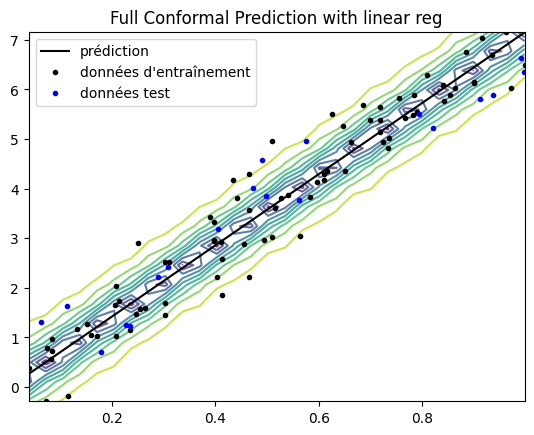

In [107]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11), alpha = .8)

plt.plot(xlist, reg_OLS.predict(xlist.reshape(-1,1)).ravel(), 'k-', label='prédiction')
plt.plot(X_train,Y_train, 'k.', label="données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'b.', label='données test')
plt.legend()
plt.title("Full Conformal Prediction with linear reg")
plt.savefig("FCP intervals linReg")


plt.show()

## for $k$-Nearest Neighbors ( $k = 9$ )

In [145]:
n=120
x=4*np.random.rand(n,1) - 2
y = x**2 + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)

xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)
reg_neigh.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=9)

In [143]:
R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_neigh)

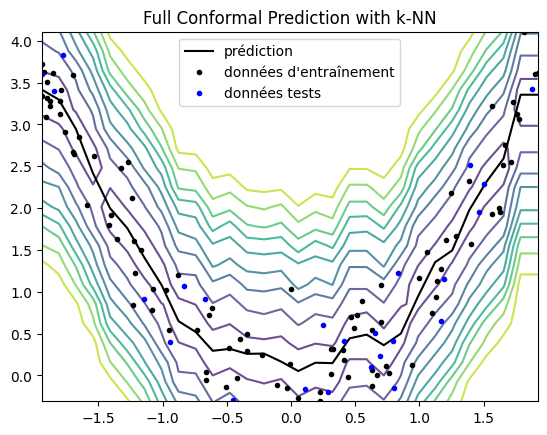

In [144]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11), alpha = .8)

plt.plot(xlist, reg_neigh.predict(xlist.reshape(-1,1)).ravel(), 'k-', label = 'prédiction')
plt.plot(X_train,Y_train, 'k.', label = "données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'b.', label='données tests')
plt.legend()
plt.title("Full Conformal Prediction with k-NN")
plt.savefig("FCP intervals k-NN")

plt.show()

## **Remarks for Full Conformal** :

Overall, it works well but is computationally expensive: For each new candidate y, fit the model with new data, and then decide whether to accept the candidate into $\hat{\mathcal{C}}$ or not.

One solution is to use the following method, the **Split Conformal**.

***

# SPLIT CONFORMAL

In a nutshell, it involves calculating **only once** $\hat{\mu}$ on a training set different from the entire dataset we have. Much less costly than Full Conformal.

**Issue**: We waste a lot of data because we use only a portion of it (the unused data still helps calibrate the result), so $\hat{\mu}$ is less accurate than in Full Conformal.

>Implementation :
>
>>1. Split our dataset $(X_i,Y_i)_{i=1,...,n}$ into 2 : a train dataset $(X_{train_i},Y_{train_i})_{i=1,...,n_{train}}$ and a calibration dataset $(X_{cal_i},Y_{cal_i})_{i=1,...,n_{cal}}$.
>>
>>2. Train $\hat{\mu}$ on $(X_{train_i},Y_{train_i})_{i=1,...,n_{train}}$
>>
>>3. Obtain a set of $n_{cal} + 1$ scores :
>>$$ \mathcal{S} = \{S_i = \big|\hat{\mu}(X_i) - Y_i\big|, i \in \text{Calibration}\} \cup \{\infty \} $$
>>
>>4. Calculate $\text{Quantile}\big(1-\alpha, \mathcal{S}\big)$ (denoted by $q_{1-\alpha}(\mathcal{S})$)
>>
>>5. For a new data point $X_{new}$, set
>>$$ \hat{\mathcal{C}}(X_{test}) = \Big[ \hat{\mu}(X_{test}) - q_{1-\alpha}(\mathcal{S}) ; \hat{\mu}(X_{test}) + q_{1-\alpha}(\mathcal{S})  \Big]$$

>**Theorem**:
>
>The same result as before applies to Split Conformal:
>
>Under the same assumptions as before, with the prediction interval constructed as indicated above, we have, for a threshold $\alpha \in [0,1]$,
>$$\mathbb{P}(y \in \hat{\mathcal{C}}(X_{test})) \ge 1-\alpha.$$

# SCP

In [133]:
def split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg, beta):
    
    '''
    x_cal, y_cal : calibration datas, vectors
    X_train, Y_train : datas to train the model, vectors
    reg : algorithm wich will train our model and then estimate new points 
    beta = 1 - alpha, choosen level

    '''
    n_cal=x_cal.shape[0]
    reg.fit(X_train, Y_train)
    
    V=np.empty(0)
    for i in range(n_cal):
        V = np.append(V, np.abs(y_cal[i]-reg.predict(x_cal[i].reshape(-1,1)))) #calcul des scores
    
    quantile = np.quantile(V,beta*(1+1/n_cal)) #quantile 1 - alpha de la fonction score empirique
    
    return quantile

***

# Jackknife+ prediction

In [123]:
def Jackknife_av_pred(x,X_train,Y_train,reg, alpha):

    '''
    x : test data points, 1x1
    X_train, Y_train : To fit
    reg : model
    alpha : threshold

    '''
    n_train=X_train.shape[0]
    
    S_down, S_up = np.zeros(n_train), np.zeros(n_train) ### S_down et S_up sont l'ensemble des bornes de l'intervalle de prédiction
    S_down, S_up = np.empty(0), np.empty(0)
    
    for i in range(n_train):
        Reg=reg ##On stocke reg dans Reg pour ne pas modifier directement reg
        
        Reg.fit(np.delete(X_train,i).reshape(-1,1),np.delete(Y_train,i).reshape(-1,1)) ### à l'itération i, on entraîne nos données sans le couple (X_i,Y_i).
        V_loo = np.abs(Y_train[i] - Reg.predict(X_train[i].reshape(-1,1))) ### Scores LOO (Leave One Out) (car on enlève le couple (X_i,Y_i) à l'iter i)

        S_down = np.append(S_down, Reg.predict(x.reshape(1,1)) - V_loo)
        S_up = np.append(S_up, Reg.predict(x.reshape(1,1)) + V_loo)
  #      S_down[i] = Reg.predict(x.reshape(1,1)) - V_loo
   #     S_up[i] = Reg.predict(x.reshape(1,1)) + V_loo
    
    quantile_inf = np.quantile(S_down, alpha/2) ## quantile alpha/2 de S_down pour avoir notre borne inf
    quantile_sup = np.quantile(S_up, 1-alpha/2) ## quantile 1 - alpha/2 de S_up pour avoir notre borne sup
    
    return quantile_inf, quantile_sup ### returns :
                                            ## quantile_inf = borne inf pour le x_test
                                            ## quantile_sup = borne sup pour le x_test

***

# CV+ prediction

In [113]:
def cross_val(x, X_train, Y_train, reg, k_fold, alpha):
    n_train = X_train.shape[0]
    kf = KFold(n_splits= k_fold)
    
    R_loo = np.zeros(n_train)
    S_down, S_up = np.zeros(n_train), np.zeros(n_train)
    
    for id_train, id_val in kf.split(X_train):
        
        Reg = reg
        Reg.fit(X_train[id_train], Y_train[id_train])
        R_loo[id_val]=np.abs(Y_train[id_val] - Reg.predict(X_train[id_val].reshape(-1,1)))
        
        S_down[id_val] = Reg.predict(x.reshape(1,1)) - R_loo[id_val]
        S_up[id_val] = Reg.predict(x.reshape(1,1)) + R_loo[id_val]
    
    quantile_inf = np.quantile(S_down, alpha/2)
    quantile_sup = np.quantile(S_up, 1-alpha/2)
    
    return quantile_inf, quantile_sup

***

## For the linear regression :

## DATA :

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [129]:
n=300
x=np.random.rand(n,1)
y=beta0*x + 1/2*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.1)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

### Jackknife+:

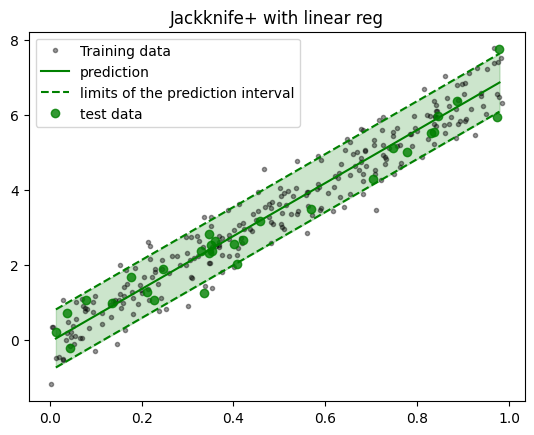

In [124]:
plt.plot(X_train, Y_train, 'k.', alpha=.4, label="Training data")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_OLS.predict(x_test[idx]), 'g-', label='prediction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_OLS, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "limits of the prediction interval")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='green', alpha=.8, label='test data')
plt.legend()
plt.title("Jackknife+ with linear reg")
plt.savefig("Jackknife with linear reg")

plt.show()

### CV+

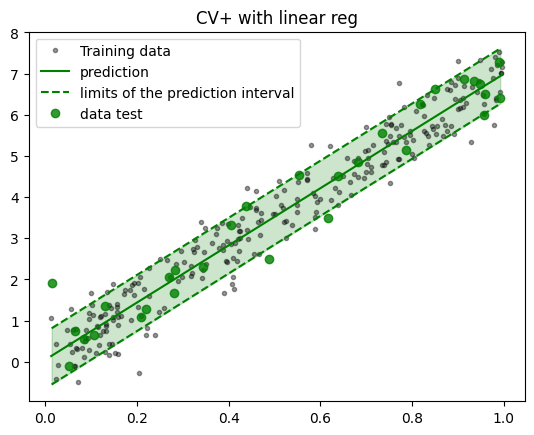

In [130]:
reg_OLS.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.',alpha=.4, label="Training data")
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_OLS.predict(X_train[idx]), 'g-',label='prediction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_OLS, 9, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "limits of the prediction interval")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='green', alpha=.8, label='data test')

plt.legend()

plt.title("CV+ with linear reg")
plt.savefig("CV+ with linear reg")

plt.show()

### SCP

In [131]:
X_train, x_cal, Y_train, y_cal = train_test_split(X_train, Y_train, test_size=0.2)

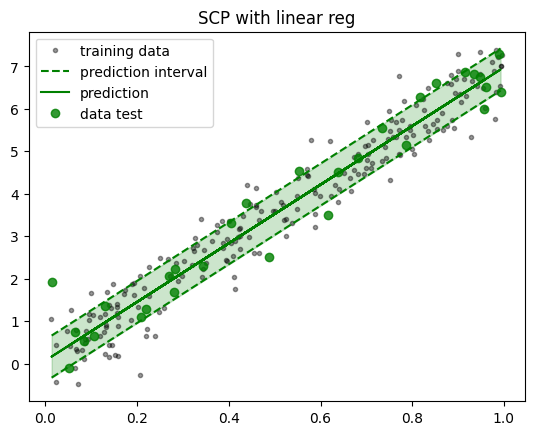

In [134]:
### plot of the prediction interval with a given threshold alpha. Here, alpha = 0.1.
n_test=x_test.shape[0]
reg_OLS.fit(X_train,Y_train)

plt.plot(X_train,Y_train,'k.', alpha=.4, label="training data")

SCP = split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg_OLS, 0.7)

idx = np.argsort(np.ravel(x_test))

low = reg_OLS.predict(x_test[idx]) - np.full(shape=(1,n_test), fill_value=SCP)
high = reg_OLS.predict(x_test[idx]) + np.full(shape=(1,n_test), fill_value=SCP)

plt.plot(x_test[idx],np.sort(low.ravel()),'g--',label='prediction interval')
plt.plot(x_test[idx],np.sort(high.ravel()),'g--')
plt.plot(x_test, reg_OLS.predict(x_test), color='green',label='prediction')

plt.fill_between(x_test[idx].reshape(-1,),np.sort(low[0,:]).reshape(-1,),np.sort(high[0,:]).reshape(-1,),color='green',alpha=.2)

plt.plot(x_test,y_test,'o', color='green',alpha=.8, label='data test')

plt.title("SCP with linear reg")
plt.legend()
plt.savefig("SCP intervals linear reg")


plt.show()

# For k-NN

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# DATA

In [136]:
n=300
x=7*np.random.rand(n,1) + 1
y=3*np.cos(x)/x + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.1)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

### Jackknife+ k-NN

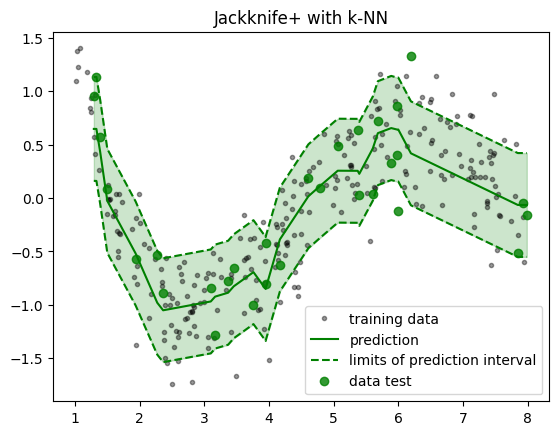

In [137]:
reg_neigh.fit(X_train,Y_train)
plt.plot(X_train, Y_train, 'k.', alpha=.4, label="training data")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_neigh.predict(x_test[idx]), 'g-',label='prediction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_neigh, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "limits of prediction interval")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='g', alpha=.8, label='data test')

plt.legend()
plt.title("Jackknife+ with k-NN")
plt.savefig("Jackknife with k-NN")

plt.show()

### CV+ k-NN

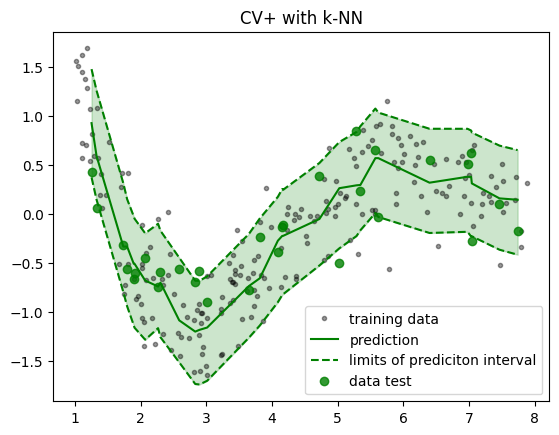

In [33]:
reg_neigh.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.', alpha=.4, label="training data")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_neigh.predict(x_test[idx]), 'g-',label='prediction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_neigh, 6, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "limits of prediciton interval")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color = 'g', alpha=.8, label='data test')

plt.legend()

plt.title("CV+ with k-NN")
plt.savefig("CV+ with k-NN")

plt.show()

### SCP k-NN

In [138]:
X_train, x_cal, Y_train, y_cal = train_test_split(X_train, Y_train, test_size=0.2)

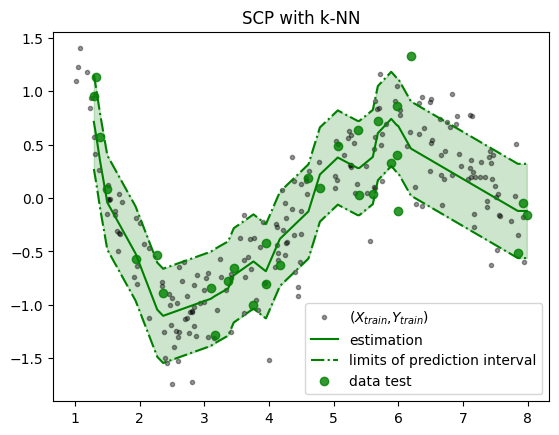

In [139]:
reg_neigh.fit(X_train, Y_train)
SCP = split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg_neigh, 0.7)

plt.plot(X_train.reshape(-1,),Y_train, 'k.', alpha=.4, label="($X_{train}$,$Y_{train}$)") 
plt.plot(np.sort(x_test[:,0]), reg_neigh.predict(np.sort(x_test[:,0]).reshape(-1,1)), color='green',label='estimation') # affichage de nos y estimés

idx = np.argsort(np.ravel(x_test))

low = reg_neigh.predict(x_test[idx]) - np.full(shape=(1,n_test), fill_value=SCP)
high = reg_neigh.predict(x_test[idx]) + np.full(shape=(1,n_test), fill_value=SCP)

plt.plot(x_test[idx], low.ravel() , 'g-.',label="limits of prediction interval")
plt.plot(x_test[idx], high.ravel(), 'g-.')

plt.fill_between(x_test[idx].reshape(-1,), low.ravel(), high.ravel(),color='green',alpha=.2)

plt.plot(x_test,y_test,'o', color='g', alpha=.8, label='data test')
plt.title("SCP with k-NN")
plt.legend()
plt.savefig("SCP intervals k-NN")

plt.show()

***

# **CLASSIFICATION**

## Split conformal :

In [36]:
import sklearn
import pandas as pd
from sklearn.datasets import load_iris

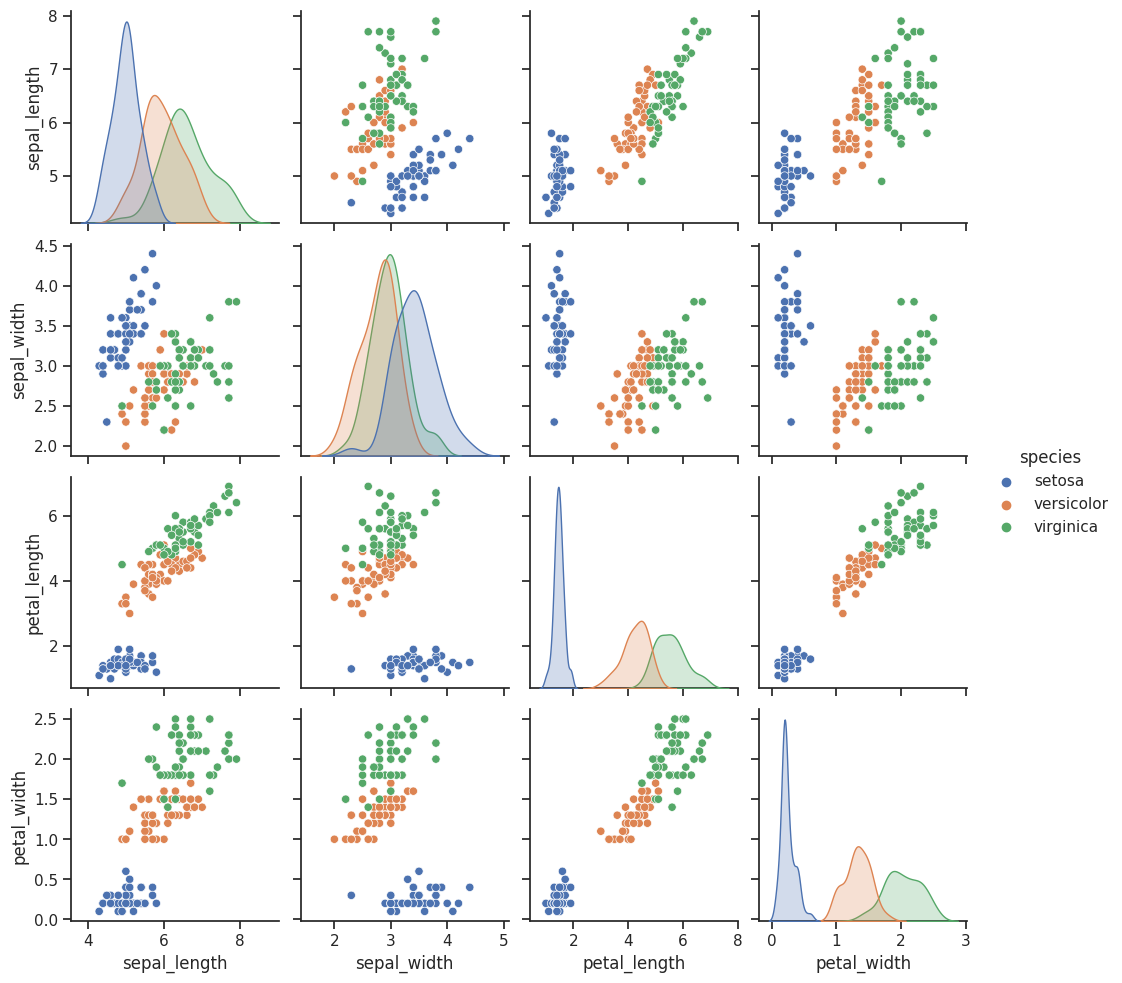

In [37]:
plantes_iris = load_iris()
df_plantes_iris = pd.DataFrame(plantes_iris.data, columns=plantes_iris.feature_names)

import seaborn as sns
sns.set(style="ticks", color_codes=True)
df_plantes_iris = sns.load_dataset("iris")
sns.pairplot(df_plantes_iris, hue="species")

labels = np.asarray(df_plantes_iris.species)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

df_selected1 = df_plantes_iris.drop(['sepal_length', 'sepal_width', "species"], axis=1)
df_features = df_selected1.to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
features = vec.fit_transform(df_features).toarray()

In [38]:
X_train, x_cal, Y_train, y_cal = train_test_split(features, labels, test_size=0.20, random_state=0)

#### Creation of the sorting algorithm:

We are dealing with the case where $X \in \mathbb{R}^2$, and $Y \in {0, 1, 2}$.
It's worth mentioning that a classifier is a measurable function $h$ from $\mathcal{X}$ to $\mathcal{Y}$. In this case, we have $\mathcal{X}=\mathbb{R}^2$ and $\mathcal{Y}={0,1,2}$.

Our classifier $h$ is currently the k-nearest neighbors classifier, so $h(X) \in {0,1,2}$.
We can obtain the probabilities for each $i \in {1,...,n}$, $\mathbb{P}(h(X_i) = k)$, denoted as $\hat{p}_k(X_i)$.

Here's the algorithm for the sorting:

1. Sort the $\hat{p}_k(X_i)$ in descending order: $\hat{p}_k(X_i)$: $\, \, \hat{p}_{\sigma_i(1)}(X_i) \geq \hat{p}_{\sigma_i(2)}(X_i) \geq \hat{p}_{\sigma_i(3)}(X_i)$.

2. Calculate all scores $S_i$ : $\,\, S_i = \sum_{k=1}^{\sigma_i^{-1}(Y_i)} \hat{p}_{\sigma_i(k)}(X_i)$.

3. At the end, return the classes $\sigma_{new}(1), ..., \sigma_{new}(r^{\star})$, where
$$
r^{\star} = \text{argmax}_{1 \leq r \leq 3} \Bigg\{\sum_{k=1}^r\hat{p}_{\sigma_{new}(k)}(X_{new}) < q_{1-\alpha}(\mathcal{S})    \Bigg\} + 1
$$


In [39]:
from sklearn.neighbors import KNeighborsClassifier
reg_neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train, Y_train)

## Naïve prediction sets

In [40]:
def SCP_classif_naif(X_train, Y_train, x_cal, y_cal, x, reg, alpha = 0.1):

    C = np.max(Y_train) + 1
    
    reg.fit(X_train, Y_train)
    
    prob_est = reg.predict_proba(x_cal)
    score = 1 - prob_est[np.arange(y_cal.size), y_cal]

    quantile = np.quantile(score,1-alpha)
    
    prob_x = reg.predict_proba(x.reshape(1,-1))
    score_x = 1 - prob_x
    
    pred = np.arange(C)[score_x.squeeze() <= quantile].squeeze()
    res = np.zeros(C, dtype=bool)
    res[pred] = True

    
    return res

### Graphical interpretation of the above code

In [41]:
data0 = np.linspace(2, 6, 40) 
data1 = np.linspace(0.4, 2.3,40) + 0.3*np.random.randn(40)

data =  np.column_stack((data0,data1))
preds = np.stack([SCP_classif_naif(X_train, Y_train, x_cal, y_cal, data[k], reg_neigh) for k in range(data.shape[0])])

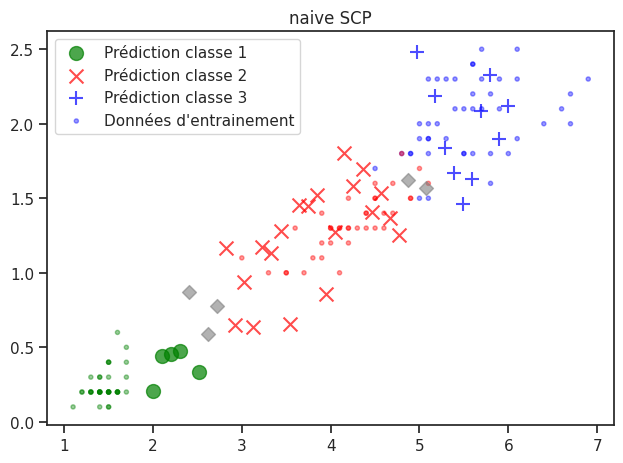

In [42]:
C = np.max(Y_train) + 1

fig, ax = plt.subplots(layout='tight')
markers = np.array(['o', 'x', '+'])
colors = np.array(['green', 'red', 'blue'])

for c in range(C):
    indices = preds[:,c] == True
    Xs = data[indices]
    ax.scatter(Xs[:,0], Xs[:,1], c=colors[c], marker=markers[c], s=100, alpha=.7, label=f"Prédiction classe {c + 1}")

ax.scatter(X_train[:,0], X_train[:,1], alpha=.4, marker='.', c=colors[Y_train], label="Données d'entrainement")

for i in range(len(preds)):
    if (preds[i,0], preds[i,1], preds[i,2]) == (False, False, False):
        ax.scatter(data[i,0], data[i,1], marker='D', s=50, color='gray',  alpha=.6)

ax.set_title("naive SCP")
ax.legend()

plt.savefig("SCP Naif 2")


plt.show()

## Adaptive prediction sets

In [43]:
def SCP_classif_aps(X_train, Y_train, x_cal, y_cal, x, reg, alpha = 0.1):
    reg.fit(X_train, Y_train)

    prob_est = reg.predict_proba(x_cal)
    cal_sorted_classes = np.fliplr(np.argsort(prob_est, axis=1))
    prob_est_sort = np.array([p[c] for (p, c) in zip(prob_est, cal_sorted_classes)])
    
    y_cal_sigma = cal_sorted_classes[np.arange(y_cal.size), y_cal]
    score = np.cumsum(prob_est_sort, axis = 1)[np.arange(y_cal.size), y_cal]

    quantile = np.quantile(score, 1-alpha)

    pred_x = reg.predict_proba(x.reshape(1,-1)).squeeze()
    sorted_classes = np.flip(np.argsort(pred_x))
    cumulative_preds = np.cumsum(pred_x[sorted_classes])
    r = 1 + (len(sorted_classes) - np.argmax(np.flip(cumulative_preds < quantile)) if (cumulative_preds < quantile).any() else 0)
    
    res = np.zeros(len(sorted_classes), dtype=bool)
    res[sorted_classes[:r]] = True
    return res

### Graphical interpretation of the above code :

In [44]:
print(SCP_classif_aps(X_train, Y_train, x_cal, y_cal, data[14], reg_neigh))

[False  True False]


In [45]:
preds = np.stack([SCP_classif_aps(X_train, Y_train, x_cal, y_cal, data[k], reg_neigh) for k in range(data.shape[0])])

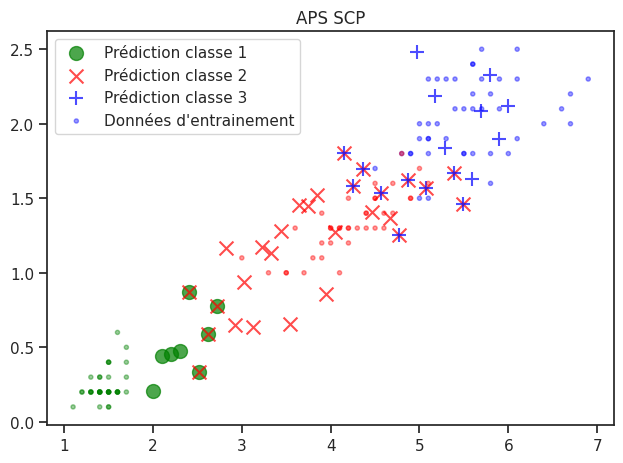

In [46]:
#plt.scatter(data0, data1, c = data_pred, marker='x', label='prédictions')
C = np.max(Y_train) + 1
fig, ax = plt.subplots(layout='tight')
markers = np.array(['o', 'x', '+'])
colors = np.array(['green', 'red', 'blue'])
for c in range(C):
    indices = preds[:,c] == True
    Xs = data[indices]
    ax.scatter(Xs[:,0], Xs[:,1], c=colors[c], marker=markers[c], s=100, alpha=.7, label=f"Prédiction classe {c+1}")
    
ax.scatter(X_train[:,0], X_train[:,1], alpha=.4, marker='.', c=colors[Y_train], label="Données d'entrainement")

ax.legend()
ax.set_title("APS SCP")
fig.savefig('scp aps example')
plt.show()